In [2]:
# Import packages
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Load data set 
x_tr_2 = np.loadtxt('./data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
x_te_2 = np.loadtxt('./data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)
y_tr_2 = np.loadtxt('./data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)

In [4]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df


In [15]:
# Split into training and validation set 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_tr_2, y_tr_2, test_size=0.333, random_state=42)

## Bench mark 

In [70]:
# Original model fit 
lrm2 = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(x_tr_2, y_tr_2) 
yproba1_test = lrm2.predict_proba(x_te_2)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

In [73]:
# Fit model with train set 
lrm2 = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(X_train, y_train) 
yproba1_original = lrm2.predict_proba(X_val)[:, 1]
loss_va = sklearn.metrics.log_loss(y_val, yproba1_original)
calc_confusion_matrix_for_threshold(y_val, yproba1_original, 0.5)

Predicted,0,1
True,,
0,1897,74
1,97,1928


In [18]:
# Function to plot the image 
def plot_img(data, h, title):
    fig, ax = plt.subplots(h, h)
    N = int(np.sqrt(data[0].size))
    for i in range(h*h):
        plt.subplot(h, h, i+1)
        plt.imshow(data[i].reshape(N, N), cmap = plt.cm.gray, vmin = 0.0, vmax = 1.0)
    plt.suptitle(title)
    return fig, ax

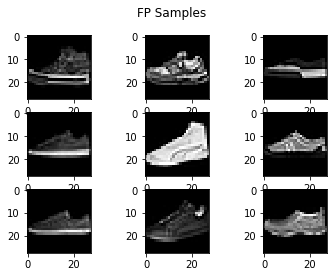

In [7]:
thre = 0.5
fpset_original = []
for i in range(len(X_val)):
    if (yproba1_original[i] >= thre and y_val[i] == 0 and len(fpset_original) < 9):
        fpset_original.append(X_val[i])
fig, ax = plot_img(fpset_original, 3, 'FP Samples')

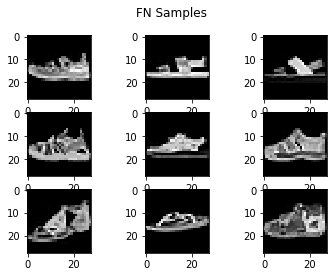

In [8]:
thre = 0.5
fnset_original = []
for i in range(len(X_val)):
    if (yproba1_original[i] <= thre and y_val[i] == 1 and len(fnset_original) < 9):
        fnset_original.append(X_val[i])
fig, ax = plot_img(fnset_original, 3, 'FN Samples')

## Flip the image horizontally

In [76]:
#Flip the image horizontally 
def flip_image(data, N):
    flip = np.empty_like(data)
    K = int(len(data[0])/N)
    for i in range(len(data)):
        img = data[i, :].reshape(N, K).tolist()
        img2 = [item[::-1] for item in img]
        img2 = np.array(img2)
        img2 = img2.reshape(1, N*K)
        img2 = img2.flatten()
        flip[i, :] = img2
    return flip

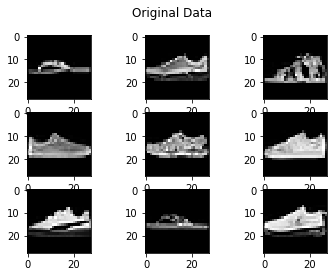

In [77]:
fig, ax = plot_img(x_te_2, 3, 'Original Data')

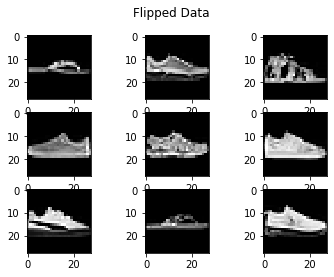

In [78]:
fig, ax = plot_img(flip_image(x_te_2, 28), 3, 'Flipped Data')

In [79]:
# Fit the model to submit to the leaderboard 
x_fl_merge = np.concatenate((x_tr_2, flip_image(x_tr_2, 28)), axis = 0)
y_fl_merge = np.concatenate((y_tr_2, y_tr_2), axis = 0)
lrm_flip = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(x_fl_merge, y_fl_merge) 
yproba1_test = lrm_flip.predict_proba(x_te_2)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

In [80]:
# Fit model with flip val data set 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_fl_merge, y_fl_merge, test_size=0.333, random_state=42)
lrm2 = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(X_train, y_train) 
yproba1_flip = lrm2.predict_proba(X_val)[:, 1]
loss_va = sklearn.metrics.log_loss(y_val, yproba1_flip)
calc_confusion_matrix_for_threshold(y_val, yproba1_flip, 0.5)

Predicted,0,1
True,,
0,3769,225
1,258,3740


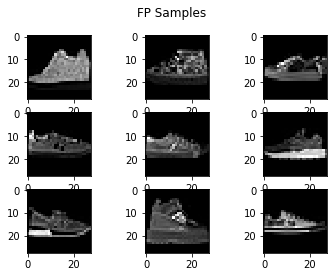

In [14]:
thre = 0.5
fpset_flip = []
for i in range(len(X_val)):
    if (yproba1_flip[i] >= thre and y_val[i] == 0 and len(fpset_flip) < 9):
        fpset_flip.append(X_val[i])
fig, ax = plot_img(fpset_flip, 3, 'FP Samples')

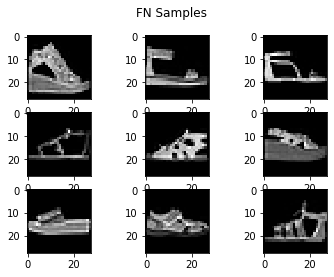

In [15]:
thre = 0.5
fnset_flip = []
for i in range(len(X_val)):
    if (yproba1_flip[i] <= thre and y_val[i] == 1 and len(fnset_flip) < 9):
        fnset_flip.append(X_val[i])
fig, ax = plot_img(fnset_flip, 3, 'FN Samples')

## Count number of black and white pixels

In [9]:
def cnt01(data):
    N = data.shape[0]
    cnt0 = np.zeros(shape = (N, 1))
    cnt1 = np.zeros(shape = (N, 1))
    newdata = np.zeros(shape = (N, 28*30))
    for i in range(len(data)):
        row = data[i, :]
        img = row.reshape(28, 28).tolist()
        cnt0 = [item.count(0) for item in img]
        cnt1 = [item.count(1) for item in img]
        cnt0 = np.array(cnt0).reshape(28, 1)
        cnt1 = np.array(cnt1).reshape(28, 1)
        img = np.array(img)
        img2 = np.concatenate((img, cnt0, cnt1), axis = 1)
        newdata[i, :] = img2.flatten()
    return newdata

In [13]:
# Version for submitting to leaderboard 
lrm_count = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(cnt01(x_tr_2), y_tr_2) 
yproba1_test = lrm_count.predict_proba(cnt01(x_te_2))[:, 1]
np.savetxt('yproba1_test2.txt', yproba1_test)

In [16]:
# Fit model with count val data set 
lrm_count = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(cnt01(X_train), y_train) 
yproba1_count = lrm_count.predict_proba(cnt01(X_val))[:, 1]
loss_va = sklearn.metrics.log_loss(y_val, yproba1_count)
calc_confusion_matrix_for_threshold(y_val, yproba1_count, 0.5)

Predicted,0,1
True,,
0,1922,49
1,81,1944


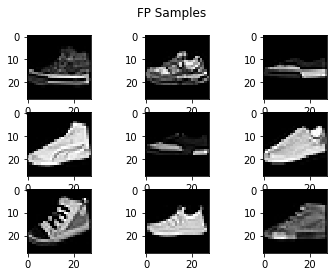

In [68]:
thre = 0.5
fpset_count = []
for i in range(len(X_val)):
    if (yproba1_count[i] >= thre and y_val[i] == 0 and len(fpset_count) < 9):
        fpset_count.append(X_val[i])
fig, ax = plot_img(fpset_count, 3, 'FP Samples')

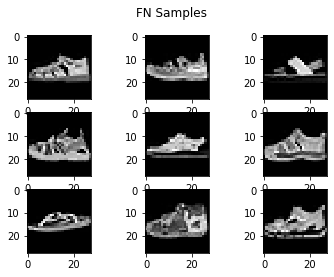

In [20]:
thre = 0.5
fnset_count = []
for i in range(len(X_val)):
    if (yproba1_count[i] <= thre and y_val[i] == 1 and len(fnset_count) < 9):
        fnset_count.append(X_val[i])
fig, ax = plot_img(fnset_count, 3, 'FN Samples')

## Histogram parts of data 

In [25]:
# Function to add the bins 
def hist(data):
    N = data.shape[0]
    nbins = 10
    newdata = np.zeros(shape = (N, 28*28+nbins))
    for i in range(len(data)):
        row = data[i, :]
        x = list(row)
        y = list(row)
        y.append(sum([1*(item < 0.1) for item in x]))
        y.append(sum([1*(0.1 <= item < 0.2) for item in x]))
        y.append(sum([1*(0.2 <= item < 0.3) for item in x]))
        y.append(sum([1*(0.3 <= item < 0.4) for item in x]))
        y.append(sum([1*(0.4 <= item < 0.5) for item in x]))
        y.append(sum([1*(0.5 <= item < 0.6) for item in x]))
        y.append(sum([1*(0.6 <= item < 0.7) for item in x]))
        y.append(sum([1*(0.7 <= item < 0.8) for item in x]))
        y.append(sum([1*(0.8 <= item < 0.9) for item in x]))
        y.append(sum([1*(0.9 <= item) for item in x]))
        newdata[i, :] = np.array(y)
    return newdata

In [26]:
x_hist_tr = hist(x_tr_2)

In [27]:
x_hist_te = hist(x_te_2)

In [55]:
# For submission
lrm_hist = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(x_hist_tr, y_tr_2) 
yproba1_test = lrm_hist.predict_proba(x_hist_te)[:, 1]
np.savetxt('yproba1_test3.txt', yproba1_test)

In [33]:
x_hist_train2 = hist(X_train)
x_hist_val = hist(X_val)

In [5]:
# lrm_hist = sklearn.linear_model.LogisticRegression(solver = 'liblinear').fit(x_hist_train2, y_train) 
# yproba1_test = lrm_hist.predict_proba(x_hist_val)[:, 1]

In [2]:
# loss_va = sklearn.metrics.log_loss(y_val, yproba1_hist)
# calc_confusion_matrix_for_threshold(y_val, yproba1_hist, 0.5)

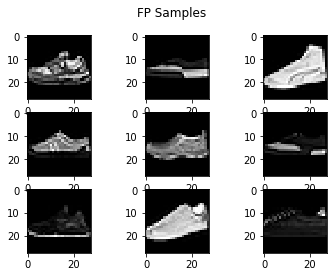

In [62]:
thre = 0.5
fpset_hist = []
for i in range(len(x_hist_val)):
    if (yproba1_test[i] >= thre and y_val[i] == 0 and len(fpset_hist) < 9):
        fpset_hist.append(X_val[i])
fig, ax = plot_img(fpset_hist, 3, 'FP Samples')

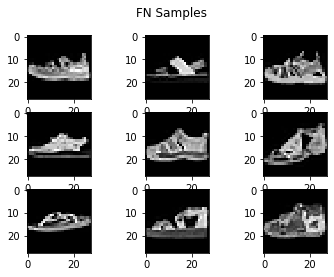

In [65]:
thre = 0.5
fnset_hist = []
for i in range(len(x_hist_val)):
    if (yproba1_test[i] <= thre and y_val[i] == 1 and len(fnset_hist) < 9):
        fnset_hist.append(X_val[i])
fig, ax = plot_img(fnset_hist, 3, 'FN Samples')

In [83]:
y_original = np.concatenate((yproba1_original, yproba1_original), axis = 0)
y_count = np.concatenate((yproba1_count, yproba1_count), axis = 0)
y_hist = np.concatenate((yproba1_hist, yproba1_hist), axis = 0)

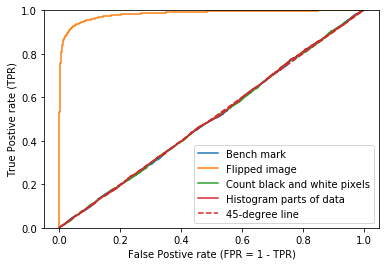

In [87]:
fpr1, tpr1, thr1 = sklearn.metrics.roc_curve(y_val, y_original)
fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_val, yproba1_flip) 
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_val, y_count) 
fpr4, tpr4, thr4 = sklearn.metrics.roc_curve(y_val, y_hist)

fig, ax = plt.subplots()
ax.plot(fpr1, tpr1, label='Bench mark')
ax.plot(fpr2, tpr2, label='Flipped image')
ax.plot(fpr3, tpr3, label='Count black and white pixels')
ax.plot(fpr4, tpr4, label='Histogram parts of data')
ax.plot(fpr2, fpr2, label='45-degree line', ls = '--', color = 'tab:red')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
ax.legend()
plt.show()

In [97]:
print(y_val.shape)
print(yproba1_original.shape)
print(yproba1_hist.size)
print(y_hist.size)

(7992,)
(3996,)
3996
7992


In [1]:
# # fpr1, tpr1, thr1 = sklearn.metrics.roc_curve(y_val, yproba1_original)
# # fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y_val, yproba1_flip) 
# fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_val, yproba1_count) 
# fpr4, tpr4, thr4 = sklearn.metrics.roc_curve(y_val, yproba1_hist)

# fig, ax = plt.subplots()
# # ax.plot(fpr1, tpr1, label='Bench mark')
# # ax.plot(fpr2, tpr2, label='Flipped image')
# ax.plot(fpr3, tpr3, label='Count black and white pixels')
# ax.plot(fpr4, tpr4, label='Histogram parts of data')
# # ax.plot(fpr2, fpr2, label='45-degree line', ls = '--', color = 'tab:red')
# plt.ylim([0, 1]);
# plt.xlabel("False Postive rate (FPR = 1 - TPR)");
# plt.ylabel("True Postive rate (TPR)");
# ax.legend()
# plt.show()